In [15]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import mlflow
from urllib.parse import urlparse
import numpy as np

In [2]:
train = pd.read_csv(r"D:\code\AppliedML_assign_02\Data\train.csv")
train_X, train_y = train.text, train.spam

test = pd.read_csv(r"D:\code\AppliedML_assign_02\Data\test.csv")
test_X, test_y = test.text, test.spam

val = pd.read_csv(r"D:\code\AppliedML_assign_02\Data\validation.csv")
val_X, val_y = val.text, val.spam

In [10]:
def eval_metrics(actual_y, pred_y):
    precision, recall, _ = precision_recall_curve(actual_y, pred_y)
    return auc(recall, precision)

Fitting the model:

1. RandomForest:

In [8]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier(random_state=1, n_estimators=100)),
])

space = dict()
space['tfidf__max_features'] = [1000, 2000, 5000]
space['rf__n_estimators'] = [50, 100, 200]

search = GridSearchCV(pipeline, space, cv=3, verbose=1, n_jobs=-1, scoring='accuracy')
result = search.fit(pd.concat([train_X, val_X], axis=0), pd.concat([train_y, val_y], axis=0))

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Score: 0.9862505443037541
Best Hyperparameters: {'rf__n_estimators': 200, 'tfidf__max_features': 5000}


In [11]:
mlflow.sklearn.autolog()

rf = search.best_estimator_
y_pred = rf.predict(test_X)
aucpr = eval_metrics(test_y, y_pred)
acc = accuracy_score(test_y, y_pred)
conf = confusion_matrix(test_y, y_pred)

with mlflow.start_run(run_name=f"tfidf__max_features : {5000}, rf__n_estimators : {200}"):
  
    mlflow.log_param("tfidf__max_features", 5000)
    mlflow.log_param("rf__n_estimators", 200)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("AUCPR",aucpr)
    mlflow.log_dict(np.array(conf).tolist(), "confusion_matrix.json")
    mlflow.sklearn.log_model(rf, "model")

    print("\nRandom Classifier Model (tfidf__max_features={:f}, rf__n_estimators={:f}):".format(5000, 200))
    print(f"Accuracy: {acc}")
    print(f"AUCPR: {aucpr} ")
    print(f"Confusion Matrix:\n {conf} \n \n")

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    mlflow.sklearn.log_model(
        sk_model=rf,
        artifact_path="sklearn-model",
        registered_model_name="random-forest-classification-model"
    )
    if tracking_url_type_store != "file":
      mlflow.sklearn.log_model(rf, "model", registered_model_name="RandomForestClassifier")
    else:
      mlflow.sklearn.log_model(rf, "model")

c:\Users\sayan\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



Random Classifier Model (tfidf__max_features=5000.000000, rf__n_estimators=200.000000):
Accuracy: 0.9860383944153578
AUCPR: 0.9732585147535276 
Confusion Matrix:
 [[866  10]
 [  6 264]] 
 



Successfully registered model 'random-forest-classification-model'.
Created version '1' of model 'random-forest-classification-model'.


2. Decision Tree:

In [12]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('dt', DecisionTreeClassifier(random_state=1)),
])

space = dict()
space['tfidf__max_features'] = [1000, 2000, 5000]
space['dt__max_depth'] = [None, 10, 20, 30]

search = GridSearchCV(pipeline, space, cv=3, verbose=1, n_jobs=-1, scoring='accuracy')
result = search.fit(pd.concat([train_X, val_X], axis=0), pd.concat([train_y, val_y], axis=0))

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

2024/02/20 17:33:04 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6bd7d2bdd45740aab615daef9b8e98a4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/02/20 17:33:04 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


Fitting 3 folds for each of 12 candidates, totalling 36 fits


c:\Users\sayan\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2024/02/20 17:33:13 INFO mlflow.sklearn.utils: Logging the 5 best runs, 7 runs will be omitted.


Best Score: 0.9611525696280219
Best Hyperparameters: {'dt__max_depth': None, 'tfidf__max_features': 1000}


In [13]:
mlflow.sklearn.autolog()

dt = search.best_estimator_
y_pred = dt.predict(test_X)
aucpr = eval_metrics(test_y, y_pred)
acc = accuracy_score(test_y, y_pred)
conf = confusion_matrix(test_y, y_pred)

with mlflow.start_run(run_name=f"tfidf__max_features : {1000}, dt__max_depth : {30}"):
  
    mlflow.log_param("tfidf__max_features", 1000)
    mlflow.log_param("dt__max_depth", 30)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("AUCPR",aucpr)
    mlflow.log_dict(np.array(conf).tolist(), "confusion_matrix.json")
    mlflow.sklearn.log_model(dt, "model")

    print("\nDecision Tree Classifier Model (tfidf__max_features={:f}, dt__max_depth={:f}):".format(1000, 30))
    print(f"Accuracy: {acc}")
    print(f"AUCPR: {aucpr} ")
    print(f"Confusion Matrix:\n {conf} \n \n")

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    mlflow.sklearn.log_model(
        sk_model=dt,
        artifact_path="sklearn-model",
        registered_model_name="decision-tree-classification-model"
    )
    if tracking_url_type_store != "file":
      mlflow.sklearn.log_model(dt, "model", registered_model_name="DecisionTreeClassifier")
    else:
      mlflow.sklearn.log_model(dt, "model")


Decision Tree Classifier Model (tfidf__max_features=1000.000000, dt__max_depth=30.000000):
Accuracy: 0.9633507853403142
AUCPR: 0.9309715927083814 
Confusion Matrix:
 [[851  25]
 [ 17 253]] 
 



Successfully registered model 'decision-tree-classification-model'.
Created version '1' of model 'decision-tree-classification-model'.


3. XGBoost:

In [19]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=1)),
])

space = dict()
space['tfidf__max_features'] = [1000, 2000, 5000]
space['xgb__max_depth'] = [6, 10, 15]  # Common depths for XGBoost
space['xgb__n_estimators'] = [100, 200, 300]  # Number of trees

search = GridSearchCV(pipeline, space, cv=3, verbose=1, n_jobs=-1, scoring='accuracy')
result = search.fit(pd.concat([train_X, val_X], axis=0), pd.concat([train_y, val_y], axis=0))

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

2024/02/20 17:39:39 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


Fitting 3 folds for each of 27 candidates, totalling 81 fits


2024/02/20 17:40:44 INFO mlflow.sklearn.utils: Logging the 5 best runs, 22 runs will be omitted.


Best Score: 0.985377372507203
Best Hyperparameters: {'tfidf__max_features': 2000, 'xgb__max_depth': 6, 'xgb__n_estimators': 200}


In [22]:
mlflow.sklearn.autolog()

xgb_model = search.best_estimator_
y_pred = xgb_model.predict(test_X)
aucpr = eval_metrics(test_y, y_pred)
acc = accuracy_score(test_y, y_pred)
conf = confusion_matrix(test_y, y_pred)

with mlflow.start_run(run_name="XGBoost Model"):
    mlflow.log_params(search.best_params_)
    mlflow.log_metric("accuracy", acc)
    # mlflow.log_metric("AUCPR", aucpr)
    mlflow.log_dict(conf.tolist(), "confusion_matrix.json")
    mlflow.sklearn.log_model(xgb_model, "model")

    print("\nXGBoost Model:")
    print(f"Accuracy: {acc}")
    print(f"AUCPR: {aucpr}")
    print(f"Confusion Matrix:\n {conf} \n \n")

tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
# Adjust the model logging based on your MLflow setup
mlflow.sklearn.log_model(
    sk_model=xgb_model,
    artifact_path="xgboost-model",
    registered_model_name="xgboost-classification-model"
)

if tracking_url_type_store != "file":
    mlflow.sklearn.log_model(xgb_model, "model", registered_model_name="XGBoostClassifier")
else:
    mlflow.sklearn.log_model(xgb_model, "model")


XGBoost Model:
Accuracy: 0.9834205933682374
AUCPR: 0.9680409859648901
Confusion Matrix:
 [[863  13]
 [  6 264]] 
 



Registered model 'xgboost-classification-model' already exists. Creating a new version of this model...
Created version '2' of model 'xgboost-classification-model'.


Clearly, RandomForest has the overall best performance out of the three classifiers tested.

In [23]:
pred_y = rf.predict(test_X)
print(classification_report(pred_y, test_y))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       872
           1       0.98      0.96      0.97       274

    accuracy                           0.99      1146
   macro avg       0.98      0.98      0.98      1146
weighted avg       0.99      0.99      0.99      1146



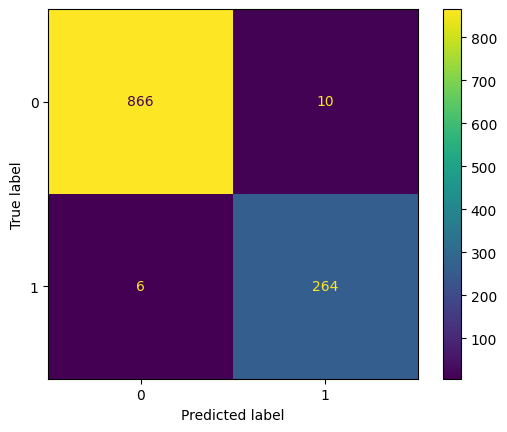

In [24]:
ConfusionMatrixDisplay.from_estimator(rf, test_X, test_y)
plt.show()